<a href="https://colab.research.google.com/github/manamendraJN/fashion-intelligence-platform/blob/feature%2Fbody-measurement-and-sizing/notebooks/body_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cell 1 - Setup and Environment Configuration

In [1]:
# PURPOSE: Install required packages, import libraries, and configure the environment
# WHY: Sets up all dependencies needed for deep learning model training

import sys
from datetime import datetime, timezone

# Print session information for tracking
print(f"Student: manamendraJN | Date: {datetime.now(timezone. utc).strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Python:  {sys.version. split()[0]}")

# Install required packages silently (-q flag)
# timm: Pre-trained vision models library
# albumentations: Advanced image augmentation library
! pip install -q timm albumentations

# Core deep learning imports
import torch
import torch.nn as nn  # Neural network layers
import torch.optim as optim  # Optimizers (AdamW)
from torch.utils.data import Dataset, DataLoader  # Data loading utilities
import timm  # Pre-trained models (EfficientNet, ResNet, MobileNet)

# Data processing imports
import numpy as np  # Numerical operations
import pandas as pd  # CSV/dataframe handling
import cv2  # Image loading
from pathlib import Path  # File path operations
import json  # Save/load configuration files

# Image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Utilities
from tqdm. auto import tqdm  # Progress bars
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical visualizations
from sklearn.metrics import r2_score  # R² metric calculation

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set device (GPU if available, else CPU)
# WHY: GPU is 10-100x faster for deep learning
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Print environment information
print(f"✅ PyTorch {torch.__version__} | Device: {device}")
if torch.cuda.is_available():
    print(f"✅ GPU:  {torch.cuda.get_device_name(0)} ({torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB)")
print("🎲 Running without fixed seeds (non-deterministic mode)")
# NOTE: No random seeds = different results each run (but more realistic generalization)

Student: manamendraJN | Date: 2025-12-11 04:53:48
Python:  3.12.12
✅ PyTorch 2.9.0+cu126 | Device: cuda
✅ GPU:  Tesla T4 (15.8 GB)
🎲 Running without fixed seeds (non-deterministic mode)


# Cell 2 - Google Drive Integration and Directory Setup

In [2]:
# PURPOSE: Mount Google Drive and create project directory structure
# WHY:  Persist data/models across Colab sessions and organize outputs

from google.colab import drive

# Mount Google Drive (force_remount=True ensures clean mount)
drive.mount('/content/drive', force_remount=True)

# Create project directory in Colab's temporary storage
# WHY: Faster read/write than Drive, we'll copy results back later
PROJECT_DIR = Path('/content/body_measurement_research')
PROJECT_DIR.mkdir(exist_ok=True)  # exist_ok=True prevents error if already exists

# Change working directory to project folder
import os
os.chdir(PROJECT_DIR)

# Create subdirectories for organized storage
# models:  Saved model weights (. pth files)
# results: JSON files with metrics and statistics
# checkpoints: Intermediate training checkpoints (not used currently)
# visualizations: Generated plots and charts
for d in ['models', 'results', 'checkpoints', 'visualizations']:
    (PROJECT_DIR / d).mkdir(exist_ok=True)

# Point to dataset location in Google Drive
# WHY: Data stays in Drive (permanent), we load from there
DRIVE_DATA_PATH = Path('/content/drive/MyDrive/body_measurement_data/train')
print(f"✅ Setup complete | Data:  {DRIVE_DATA_PATH}")

Mounted at /content/drive
✅ Setup complete | Data:  /content/drive/MyDrive/body_measurement_data/train


# Cell 3 - Load Dataset from CSV Files


In [3]:
# PURPOSE: Load and merge three CSV files containing photos, measurements, and metadata
# WHY: We need to combine subject IDs with their photos and body measurements

# Load three separate CSV files
# 1. subject_to_photo_map. csv: Maps subject_id → photo_id
# 2. measurements. csv: Contains 14 body measurements per subject_id
# 3. hwg_metadata.csv: Contains height, weight, gender per subject_id
photos_df = pd.read_csv(DRIVE_DATA_PATH / 'subject_to_photo_map.csv')
measurements_df = pd.read_csv(DRIVE_DATA_PATH / 'measurements.csv')
metadata_df = pd.read_csv(DRIVE_DATA_PATH / 'hwg_metadata.csv')

# Merge dataframes on 'subject_id' column
# WHY: We need photo_id, measurements, and metadata in one table
# how='inner':  Only keep subjects that exist in ALL three files
data = photos_df.merge(measurements_df, on='subject_id', how='inner')
data = data.merge(metadata_df, on='subject_id', how='inner')

# Extract measurement column names (exclude non-measurement columns)
# WHY: We need to know which columns are our prediction targets
exclude_cols = ['subject_id', 'Unnamed: 0']  # Remove ID columns
MEASUREMENT_COLUMNS = [col for col in measurements_df.columns if col not in exclude_cols]
# Result: 14 measurements (chest, waist, hip, shoulder, arm, leg, etc.)

print(f"✅ Loaded {len(data)} samples | {len(MEASUREMENT_COLUMNS)} measurements")

✅ Loaded 6134 samples | 14 measurements


# Cell 4 - Dataset Visualization and Exploration

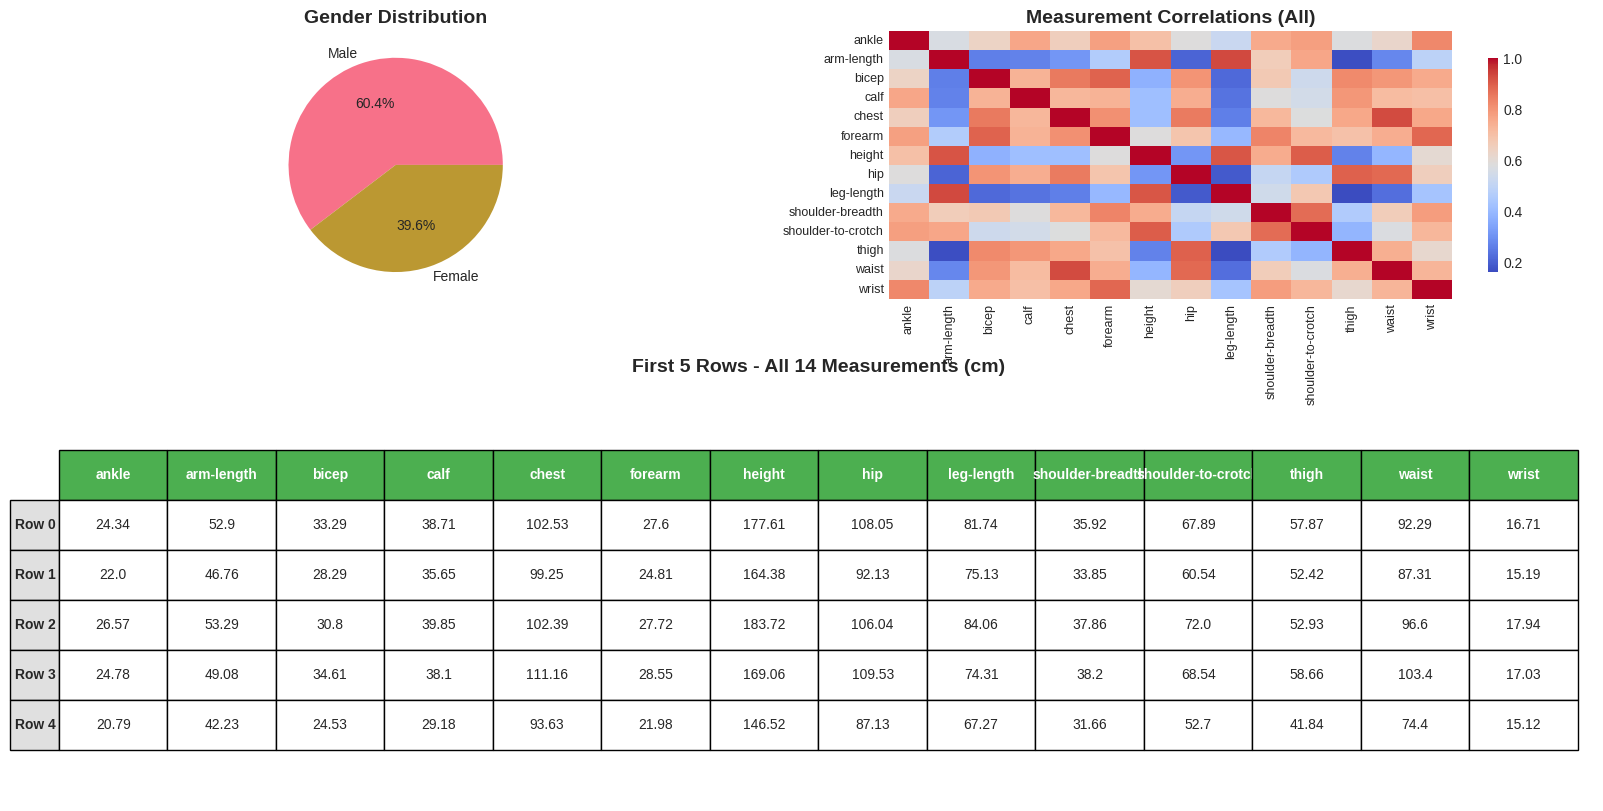

✅ Saved:  visualizations/dataset_overview.png


In [13]:
# PURPOSE: Create visualizations to understand dataset distribution and characteristics
# WHY: Important to know data balance, ranges, and correlations before training

# Create figure with custom layout
fig = plt.figure(figsize=(20, 10))

# Create grid:  2 rows, gender and correlation on top, table takes full bottom row
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.5], hspace=0.3)

# PLOT 1: Gender distribution (pie chart)
# WHY: Check if dataset is balanced between male/female
ax1 = fig.add_subplot(gs[0, 0])
ax1.pie(metadata_df['gender']. value_counts(), labels=['Male', 'Female'], autopct='%1.1f%%')
ax1.set_title('Gender Distribution', fontsize=14, fontweight='bold')

# PLOT 2:  Correlation heatmap (ALL measurements)
# WHY: See which measurements are related (e.g., chest and shoulder width)
ax2 = fig.add_subplot(gs[0, 1])
corr = measurements_df[MEASUREMENT_COLUMNS]. corr()
sns.heatmap(corr, annot=False, ax=ax2, cmap='coolwarm', cbar_kws={'shrink': 0.8})
ax2.set_title('Measurement Correlations (All)', fontsize=14, fontweight='bold')
ax2.tick_params(axis='both', labelsize=9)

# PLOT 3: First 5 rows of dataset with ALL measurements
# WHY: Show actual data samples to understand dataset structure
ax3 = fig.add_subplot(gs[1, : ])  # Spans both columns
ax3.axis('off')

# Show all measurements for first 5 rows
sample_data = measurements_df[MEASUREMENT_COLUMNS].head(5)

# Create table with better formatting
table = ax3.table(
    cellText=sample_data.values. round(2),  # Round to 2 decimal places
    rowLabels=[f'Row {i}' for i in sample_data.index],
    colLabels=sample_data.columns,
    loc='center',
    cellLoc='center',
    colWidths=[0.07] * len(MEASUREMENT_COLUMNS)  # Equal width for all columns
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 3)

# Color header row
for i in range(len(MEASUREMENT_COLUMNS)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color row labels
for i in range(1, 6):
    table[(i, -1)].set_facecolor('#E0E0E0')
    table[(i, -1)].set_text_props(weight='bold')

ax3.set_title('First 5 Rows - All 14 Measurements (cm)', fontsize=14, fontweight='bold', pad=20)

# Save and display (removed tight_layout to avoid warning)
plt.savefig('visualizations/dataset_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved:  visualizations/dataset_overview.png")